# BTS Tryout
### ***This notebook is meant to be run on Google Colab*** - [link to a live version](https://colab.research.google.com/drive/1gFee5NXeCScYuGLiHqDn8twsbUflTHJs)

There are 3 sections in this notebook:
1. Preparing the BTS repository found [here](https://github.com/cogaplex-bts/bts)
2. A simple demo that let's you upload your own photo to Colab, and then returns a depth map of that image. Both the input and depth maps are saved in the following path – `/workspace/bts/pytorch/images`
3. Running the built in test set from the dataset NYU Depth V2, and viewing the resulting metrics.

This notebook is intended as a qualitative baseline for the [SavtaDepth](https://dagshub.com/OperationSavta/SavtaDepth) project which is an Open Source Data Science project. We'd love to get help from the community, so if you'd like to contribute head over to the [project page](https://dagshub.com/OperationSavta/SavtaDepth) to get started.



## Prepare all implemenatations

In [ ]:
!mkdir workspace
%cd workspace/
!mkdir dataset
!git clone https://github.com/cogaplex-bts/bts.git

/content/workspace
Cloning into 'bts'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 334 (delta 8), reused 10 (delta 4), pack-reused 314
Receiving objects: 100% (334/334), 639.37 KiB | 2.50 MiB/s, done.
Resolving deltas: 100% (205/205), done.


### Download Model

In [ ]:
%cd bts/pytorch/
!mkdir models
%cd models
!wget https://cogaplex-bts.s3.ap-northeast-2.amazonaws.com/bts_nyu_v2_pytorch_densenet161.zip
!unzip bts_nyu_v2_pytorch_densenet161.zip
%cd ../

/content/workspace/bts/pytorch
/content/workspace/bts/pytorch/models
--2020-08-08 19:12:56--  https://cogaplex-bts.s3.ap-northeast-2.amazonaws.com/bts_nyu_v2_pytorch_densenet161.zip
Resolving cogaplex-bts.s3.ap-northeast-2.amazonaws.com (cogaplex-bts.s3.ap-northeast-2.amazonaws.com)... 52.219.60.15
Connecting to cogaplex-bts.s3.ap-northeast-2.amazonaws.com (cogaplex-bts.s3.ap-northeast-2.amazonaws.com)|52.219.60.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500441014 (477M) [application/zip]
Saving to: ‘bts_nyu_v2_pytorch_densenet161.zip’

bts_nyu_v2_pytorch_ 100%[===================>] 477.26M  25.0MB/s    in 20s     

2020-08-08 19:13:17 (23.4 MB/s) - ‘bts_nyu_v2_pytorch_densenet161.zip’ saved [500441014/500441014]

Archive:  bts_nyu_v2_pytorch_densenet161.zip
   creating: bts_nyu_v2_pytorch_densenet161/
  inflating: bts_nyu_v2_pytorch_densenet161/arguments_train_nyu.txt  
  inflating: bts_nyu_v2_pytorch_densenet161/bts_nyu_v2_pytorch_densenet161.py  
  

## Demo of BTS

### Upload Test Image

mkdir: cannot create directory ‘images’: File exists
/content/workspace/bts/pytorch/images


Saving guy.jpg to guy.jpg


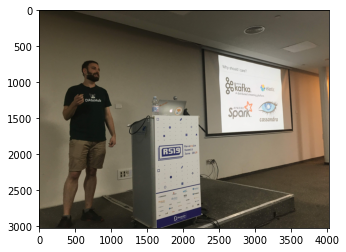

/content/workspace/bts/pytorch


In [ ]:
!mkdir images
%cd images/

# Upload Image
uploaded = files.upload()
original = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))
im = np.asarray(original)


# Pad Image to next power of 2
def power_log(x):
    return 2**(math.ceil(math.log(x, 2)))

padded_width = power_log(im.shape[0])
padded_height = power_log(im.shape[1]) - im.shape[1]

# Calculating how much padding needs to be added
padding_width = power_log(im.shape[0]) - im.shape[0]
padding_height = power_log(im.shape[1]) - im.shape[1]

padded_im = np.pad(im, ((math.floor(padding_width/2),math.ceil(padding_width/2)),(math.floor(padding_height/2),math.ceil(padding_height/2)),(0,0)), 'edge')
padded_im = resize(padded_im, (math.floor(padded_im.shape[0]/2), math.floor(padded_im.shape[1]/2)))

# Preview original image
plt.imshow(im)
plt.show()

%cd ../

### Prepare Model

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from bts import BtsModel
import os
from google.colab import files
from io import BytesIO
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Visualization
import matplotlib.pyplot as plt
import math

plasma = plt.get_cmap('plasma')
greys = plt.get_cmap('Greys')

In [ ]:
# Arguments
class Args:
  pass

args = Args()
args.model_name = 'bts_nyu_v2_pytorch_densenet161'
args.encoder = 'densenet161_bts'
args.checkpoint_path = './models/bts_nyu_v2_pytorch_densenet161/model'
args.max_depth = 10
args.bts_size = 512
args.dataset = 'nyu'

# Setting image dimensions:
args.input_width = padded_im.shape[0]
args.input_height = padded_im.shape[1]

In [ ]:
# Load Model
def load_model():
  args.mode = 'test'
  model = BtsModel(params=args)
  model = torch.nn.DataParallel(model)

  checkpoint = torch.load(args.checkpoint_path)
  model.load_state_dict(checkpoint['model'])
  model.eval()
  model.cuda()
  
  return model

bts_model = load_model()

### Predict Depth

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


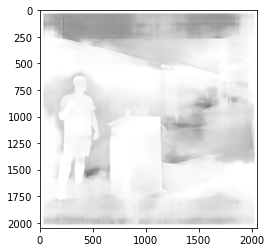

In [ ]:
def predict(model, image_in):
  input_image = (image_in[:, :, :3]*255).astype(np.float32)

  # Normalize image
  input_image[:, :, 0] = (input_image[:, :, 0] - 123.68) * 0.017
  input_image[:, :, 1] = (input_image[:, :, 1] - 116.78) * 0.017
  input_image[:, :, 2] = (input_image[:, :, 2] - 103.94) * 0.017

  input_image_cropped = input_image[32:-1 - 31, 32:-1 - 31, :]

  input_images = np.expand_dims(input_image_cropped, axis=0)
  input_images = np.transpose(input_images, (0, 3, 1, 2))

  with torch.no_grad():
      image = Variable(torch.from_numpy(input_images)).cuda()
      focal = Variable(torch.tensor([518.8579])).cuda()
      # Predict
      lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_cropped = model(image, focal)
  
  depth = np.zeros((args.input_height,args.input_width), dtype=np.float32)
  depth[32:-1-31, 32:-1-31] = depth_cropped[0].cpu().squeeze() / args.max_depth
  coloredDepth = (greys(np.log10(depth * args.max_depth))[:, :, :3] * 255).astype('uint8')

  plt.imshow(coloredDepth)
  plt.show()

  return coloredDepth

# Make prediction
depth_map = predict(bts_model, padded_im)

# Crop image to take into account padding and save depth map
fixed_depth_map = resize(depth_map, (padded_im.shape[0]*2, padded_im.shape[1]*2))
fixed_depth_map = (fixed_depth_map[math.floor(padding_width/2):math.floor(padding_width/2) + im.shape[0], math.floor(padding_height/2):math.floor(padding_height/2) + im.shape[1], :] * 255).astype('uint8')
depth_map_img = Image.fromarray(fixed_depth_map)
depth_map_img.save('./images/input_depth.png')

# Crop original image and save
cropped_image = Image.fromarray(im)
cropped_image.save('./images/input.png')

In [ ]:
# Cleanup
!rm images/*

## Run BTS on NYU Depth V2 Test set

### Prepare NYU Depth V2 test set

In [ ]:
%cd ../utils
!wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
!python extract_official_train_test_set_from_mat.py nyu_depth_v2_labeled.mat splits.mat ../../dataset/nyu_depth_v2/official_splits/

### Run on Test Data from NYU Depth V2

In [ ]:
!python bts_test.py arguments_test_nyu.txt

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100% 110M/110M [00:04<00:00, 28.7MB/s]
now testing 654 files with ./models/bts_nyu_v2_pytorch_densenet161/model
  0% 0/654 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
100% 654/654 [03:16<00:00,  3.33it/s]
Elapesed time: 196.3070774078369
Done.
Saving result pngs..
100% 654/654 [00:12<00:00, 50.56it/s]


### Evaluate results

In [ ]:
!python ../utils/eval_with_pngs.py --pred_path result_bts_nyu_v2_pytorch_densenet161/raw/ --gt_path ../../dataset/nyu_depth_v2/official_splits/test/ --dataset nyu --min_depth_eval 1e-3 --max_depth_eval 10 --eigen_crop

Raw png files reading done
Evaluating 654 files
GT files reading done
0 GT files missing
Computing errors
     d1,      d2,      d3,  AbsRel,   SqRel,    RMSE, RMSElog,   SILog,   log10
  0.885,   0.978,   0.994,   0.110,   0.066,   0.392,   0.142,  11.534,   0.047
Done.
